In [ ]:
import torch
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import umap.umap_ as umap
import pickle
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
from utils.args import args

## Function definitions for data reorganization and plotting

In [44]:
'''
    args:
        - features_data: dict of features extracted ("features", list(uid,video_name,features_RGB))
        - dataframe: for each unique frame (udi,partecipant_id,video_id,narration,start_timestamp,stop_timestamp,start_frame,stop_frame,verb,verb_class)
    return:
        - extracted_features: DataFrame with the extracted_features of the modality of interest, the related image path of the middle frame and the label associated with the clip
'''
def get_features_labels_ek(features_data, dataframe) -> pd.DataFrame:
    
    data = []

    for _, features_list in features_data.items():

        for features in features_list:

            feat_clip = features.get(f"features_RGB")

            info_clip = dataframe[dataframe["uid"] == features.get("uid")]

            start_frame = info_clip['start_frame'].tolist()
            stop_frame = info_clip['stop_frame'].tolist()
            central_image = (stop_frame[0] - start_frame[0]) // 2 + start_frame[0]

            frames_path = f'./ek_data/frames/' + features.get("video_name")
            image_path = frames_path + "/" + [frame for frame in os.listdir(frames_path) if str(central_image) in frame][0]
            
            data.append({
                "features": feat_clip,
                "image": image_path,
                "uid": info_clip["uid"].values[0],
                "verb_class": info_clip["verb_class"].values[0]
            })

    return pd.DataFrame(data)

def get_features_labels_an(features_data, dataframe, modality="RGB") -> pd.DataFrame:

    data = []
    
    for _, features_list in features_data.items():
        for features in features_list:
            feat_clip = features.get(f"features_{modality}")
            info_clip = dataframe[dataframe["uid"] == features.get("uid")]

            if modality == "RGB":
                start_frame = info_clip['start_frame'].tolist()
                stop_frame = info_clip['stop_frame'].tolist()
                central_image = (stop_frame[0] - start_frame[0]) // 2 + start_frame[0]

                shifted_frame = central_image

                # Format the central frame number to match 'frame_%04d.png'
                frame_filename = f'frame_{shifted_frame:04d}.png'
                frames_path = './an_data/frames/'
                image_path = os.path.join(frames_path, frame_filename)

                data.append({
                    "features": feat_clip,
                    "image": image_path,
                    "uid": info_clip["uid"].values[0],
                    "verb_class": info_clip["verb_class"].values[0]
                })
            else:
                data.append({
                    "features": feat_clip,
                    "uid": info_clip["uid"].values[0],
                    "verb_class": info_clip["verb_class"].values[0]
                })
    
    return pd.DataFrame(data)

def plot_features_labels_clusters_ek(path, dataframe, title=""):
    with open(path, 'rb') as file:
        features_data = pickle.load(file)

    data = get_features_labels_ek(features_data, dataframe)

    features = data["features"]
    # features is a list of 435 elements (one for clip) of 5*1024 features rgb * clip (5 vectors of 1024 elements)
    aggregated_features = []
    for f in features:
        aggregated_features.append(np.mean(f, axis=0))
    # aggregated_features is a list of 435 elements (one for clip) of 1024 features rgb * clip

    num_clusters = 8

    # Initialize K-Means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(aggregated_features)
    data['cluster'] = cluster_labels

    # reduced = TSNE(n_components=2, learning_rate="auto", random_state=0, verbose=0, init="pca").fit_transform(np.array(aggregated_features))
    reducer = umap.UMAP(n_components=2)
    reduced = reducer.fit_transform(np.array(aggregated_features))
    data['x'] = reduced[:, 0]
    data['y'] = reduced[:, 1]

    # Define labels and colors
    LABELS = {
        0: "take (get)",
        1: "put-down (put/place)",
        2: "open",
        3: "close",
        4: "wash (clean)",
        5: "cut",
        6: "stir (mix)",
        7: "pour"
    }
    COLORS = {i: x for i, x in enumerate(sns.color_palette("tab10", len(LABELS)).as_hex())}

    plt.figure(figsize=(18, 9))
    plt.suptitle(f"UMAP Visualization for {title}")

    plt.subplot(1, 2, 1)
    for i in range(len(LABELS.keys())):
        filtered = data[data['verb_class'] == i]
        plt.scatter(filtered['x'], filtered['y'], c=COLORS[i], label=LABELS[i])
    plt.legend()
    plt.title("Features with annotations")

    plt.subplot(1, 2, 2)
    for i in range(len(LABELS.keys())):
        filtered = data[data['cluster'] == i]
        plt.scatter(filtered['x'], filtered['y'], c=COLORS[i], label='Cluster - ' + str(i))
    plt.legend()
    plt.title("KMeans Clusters")

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
    plt.show()
    plt.close()


def plot_features_labels_clusters_an(path, dataframe, title="", modality="RGB"):
    with open(path, 'rb') as file:
        features_data = pickle.load(file)

    data = get_features_labels_an(features_data, dataframe, modality)

    features = data["features"]
    aggregated_features = [np.mean(f, axis=0) for f in features]

    # Determine the number of clusters based on the unique verb classes
    num_clusters = len(set(data["verb_class"]))

    # Initialize K-Means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(aggregated_features)
    data['cluster'] = cluster_labels

    # Apply UMAP for dimensionality reduction
    #reducer = umap.UMAP(n_components=2)
    # reduced = reducer.fit_transform(np.array(aggregated_features))
    
    reduced = TSNE(n_components=2, learning_rate="auto", random_state=0, verbose=0, init="pca").fit_transform(np.array(aggregated_features))
    data['x'] = reduced[:, 0]
    data['y'] = reduced[:, 1]

    # Define activity labels and colors
    activity_labels = {
        'Get/replace items from refrigerator/cabinets/drawers': 0,
        'Peel a cucumber': 1,
        'Clear cutting board': 2,
        'Slice a cucumber': 3,
        'Peel a potato': 4,
        'Slice a potato': 5,
        'Slice bread': 6,
        'Spread almond butter on a bread slice': 7,
        'Spread jelly on a bread slice': 8,
        'Open/close a jar of almond butter': 9,
        'Pour water from a pitcher into a glass': 10,
        'Clean a plate with a sponge': 11,
        'Clean a plate with a towel': 12,
        'Clean a pan with a sponge': 13,
        'Clean a pan with a towel': 14,
        'Get items from cabinets: 3 each large/small plates, bowls, mugs, glasses, sets of utensils': 15,
        'Set table: 3 each large/small plates, bowls, mugs, glasses, sets of utensils': 16,
        'Stack on table: 3 each large/small plates, bowls': 17,
        'Load dishwasher: 3 each large/small plates, bowls, mugs, glasses, sets of utensils': 18,
        'Unload dishwasher: 3 each large/small plates, bowls, mugs, glasses, sets of utensils': 19,
    }

    reverse_activity_labels = {v: k for k, v in activity_labels.items()}
    COLORS = {i: x for i, x in enumerate(sns.color_palette("tab20", num_clusters).as_hex())}

    plt.figure(figsize=(16, 16))
    plt.suptitle(f"UMAP Visualization for {title}")

    plt.subplot(2, 1, 1)
    for i in range(num_clusters):
        filtered = data[data['verb_class'] == i]
        plt.scatter(filtered['x'], filtered['y'], c=COLORS[i], label=reverse_activity_labels[i])
    plt.legend(loc='best', bbox_to_anchor=(1, 1))
    plt.title("Features with annotations")

    plt.subplot(2, 1, 2)
    for i in range(num_clusters):
        filtered = data[data['cluster'] == i]
        plt.scatter(filtered['x'], filtered['y'], c=COLORS[i], label='Cluster - ' + str(i))
    plt.legend(loc='best', bbox_to_anchor=(1, 1))
    plt.title("KMeans Clusters")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    plt.close()

def plot_features_images(path, dataframe, title="", dataset="ek", modality="RGB"):

    with open(path, 'rb') as file:
        features_data = pickle.load(file)

    if dataset == "ek":
        data = get_features_labels_ek(features_data, dataframe)
    else:
        data = get_features_labels_an(features_data, dataframe)

    features = data["features"]
    # features is a list of 435 elements (one for clip) of 5*1024 features rgb * clip (5 vectors of 1024 elements)
    aggregated_features = []
    for f in features:
        aggregated_features.append(np.mean(f, axis=0))
    # aggregated_features is a list of 435 elements (one for clip) of 1024 features rgb * clip
    
    reducer = umap.UMAP(n_components=2)
    reduced = reducer.fit_transform(np.array(aggregated_features))
    data['x'] = reduced[:, 0]
    data['y'] = reduced[:, 1]

    fig, ax = plt.subplots(figsize=(20, 12)) 
    plt.suptitle(f"UMAP Visualization with Frames for {title}")

    # Center the plot
    ax.set_xlim(min(data['x']) - 1, max(data['x']) + 1)
    ax.set_ylim(min(data['y']) - 1, max(data['y']) + 1)

    for i in range(len(data)):
        image_path = data['image'][i]
        x0, y0 = data['x'][i], data['y'][i]
        img = Image.open(image_path)
        img.thumbnail((200, 200), Image.Resampling.LANCZOS)
        imagebox = OffsetImage(img, zoom=0.5)
        ab = AnnotationBbox(imagebox, (x0, y0), frameon=False)
        ax.add_artist(ab)

    plt.show()
    plt.close()


## EPIC-Kitchens plots

In [ ]:
with open('./train_val/D1_train.pkl', 'rb') as file:
        data = pickle.load(file)
        df = pd.DataFrame(data)

if args.gpus is not None:
        os.environ['CUDA_VISIBLE_DEVICES'] = args.gpus
else:
        os.environ['CUDA_VISIBLE_DEVICES'] = "2"
        os.environ['OMP_NUM_THREADS'] = "2"
        

In [ ]:
plot_features_labels_clusters_ek('./saved_features/EK_D1_5_dense_save.pkl', df, "EK 5 frames - Dense sampling" )

In [ ]:
plot_features_labels_clusters_ek('./saved_features/EK_D1_25_dense_save.pkl', df, "EK 25 frames - Dense sampling" )

In [ ]:
plot_features_labels_clusters_ek('./saved_features/EK_D1_25_uniform_save.pkl', df, "EK 25 frames - Uniform sampling" )

In [ ]:
plot_features_images('./saved_features/EK_D1_5_dense_save.pkl', df, "EK 5 frames - Dense sampling" )

## ActionNet plots

In [47]:
with open('./labels_AN/labels_S04/S04_train.pkl', 'rb') as file:
    data1 = pickle.load(file)
    df_an_04 = pd.DataFrame(data1)

c:\Users\Nunzi\anaconda3\envs\aml23-ego\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


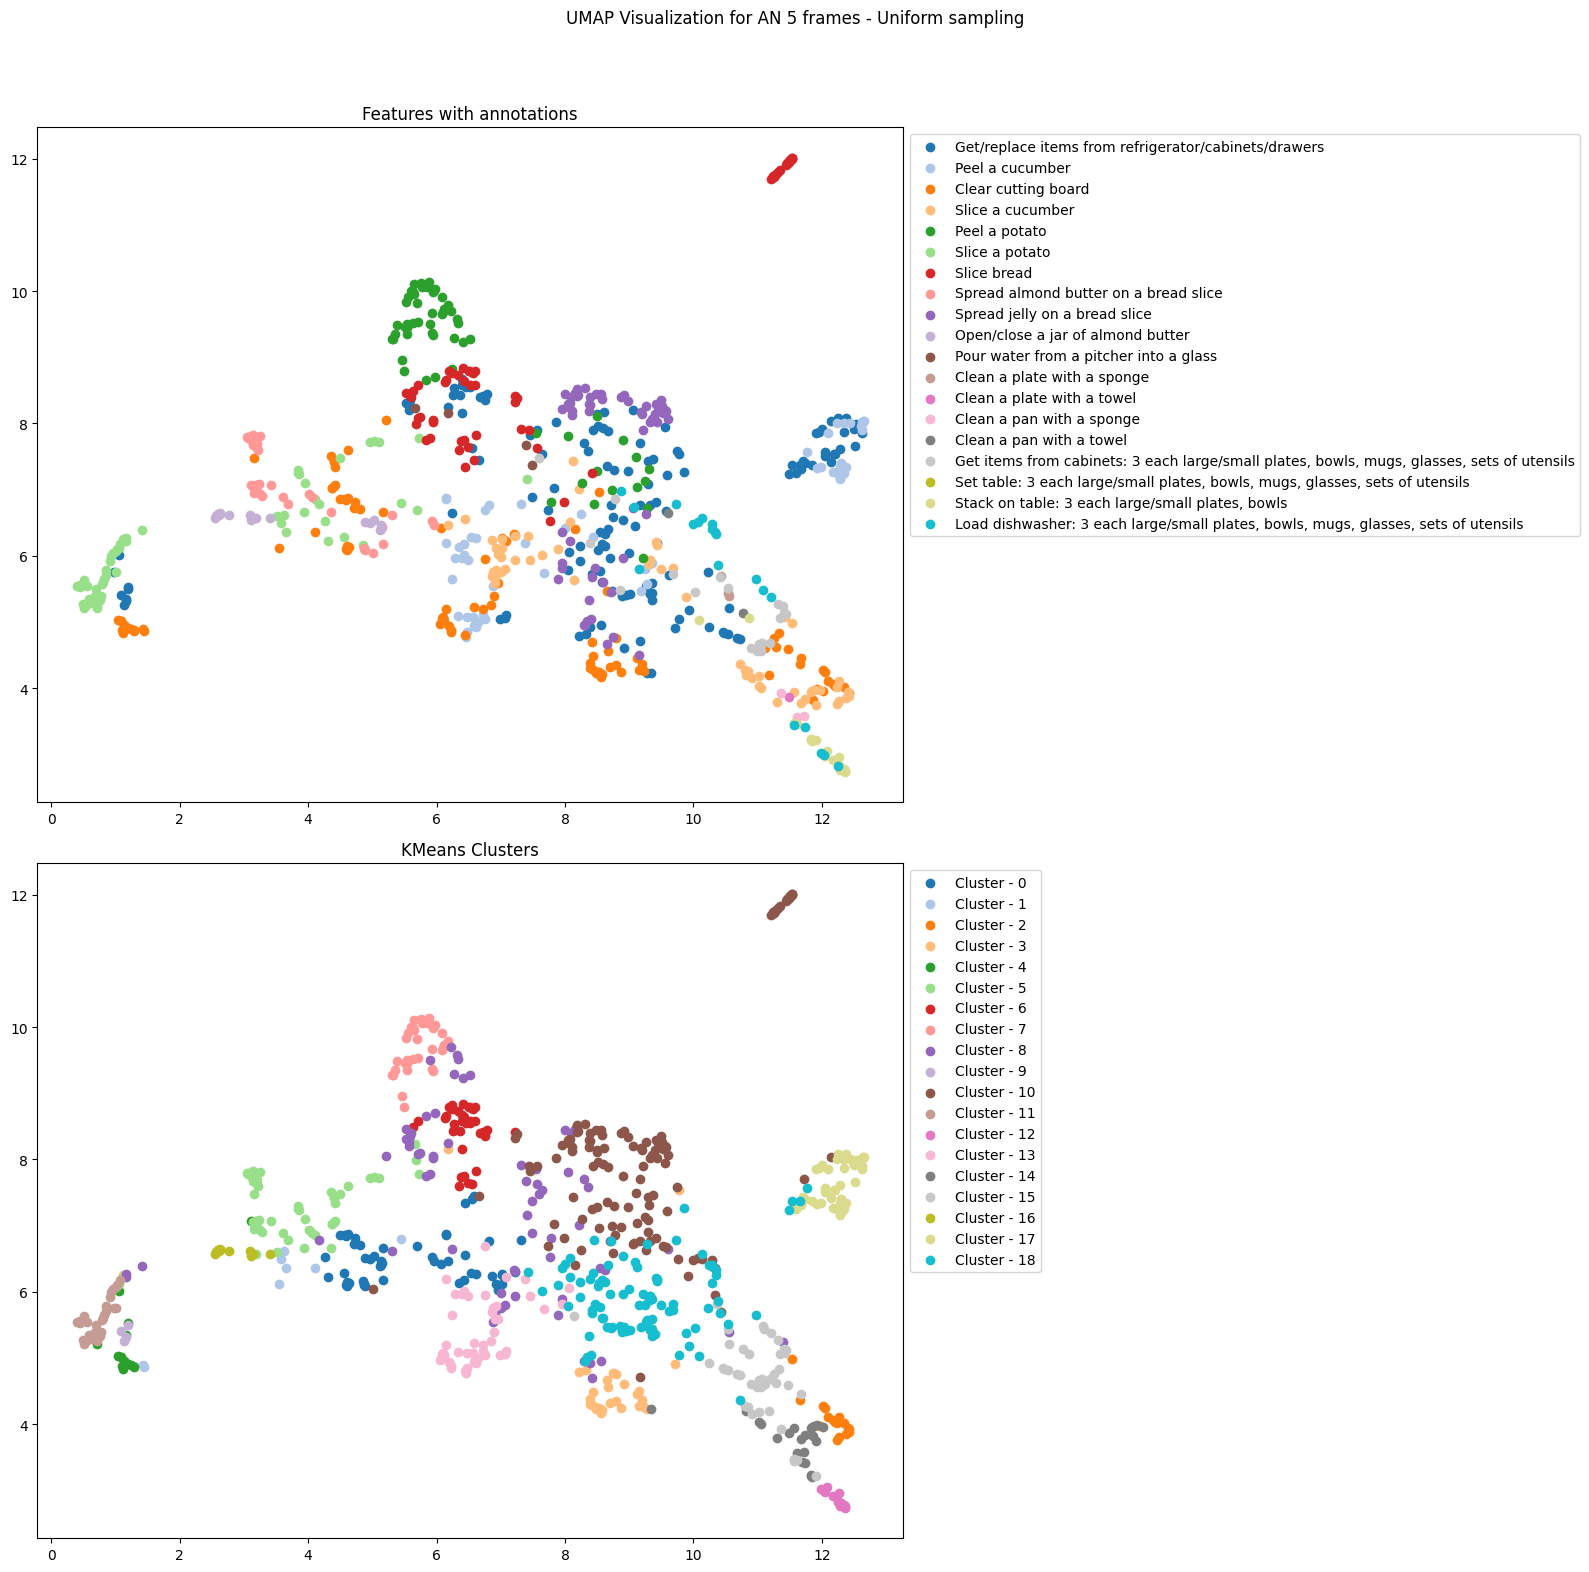

In [18]:
plot_features_labels_clusters_an('./RGB_preprocessed/feat_rgb_5_False_train_S04_train.pkl', df_an_04, "AN RGB 5 frames - Uniform sampling")

In [ ]:
plot_features_images('./RGB_preprocessed/feat_rgb_5_False_train_S04_train.pkl', df_an_04, "AN RGB 5 frames - Uniform sampling","an")

In [30]:
with open('./labels_AN/labels_full_dataset/ActionNet_train.pkl', 'rb') as file:
    data2 = pickle.load(file)
    df_an_full = pd.DataFrame(data2)

c:\Users\Nunzi\anaconda3\envs\aml23-ego\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


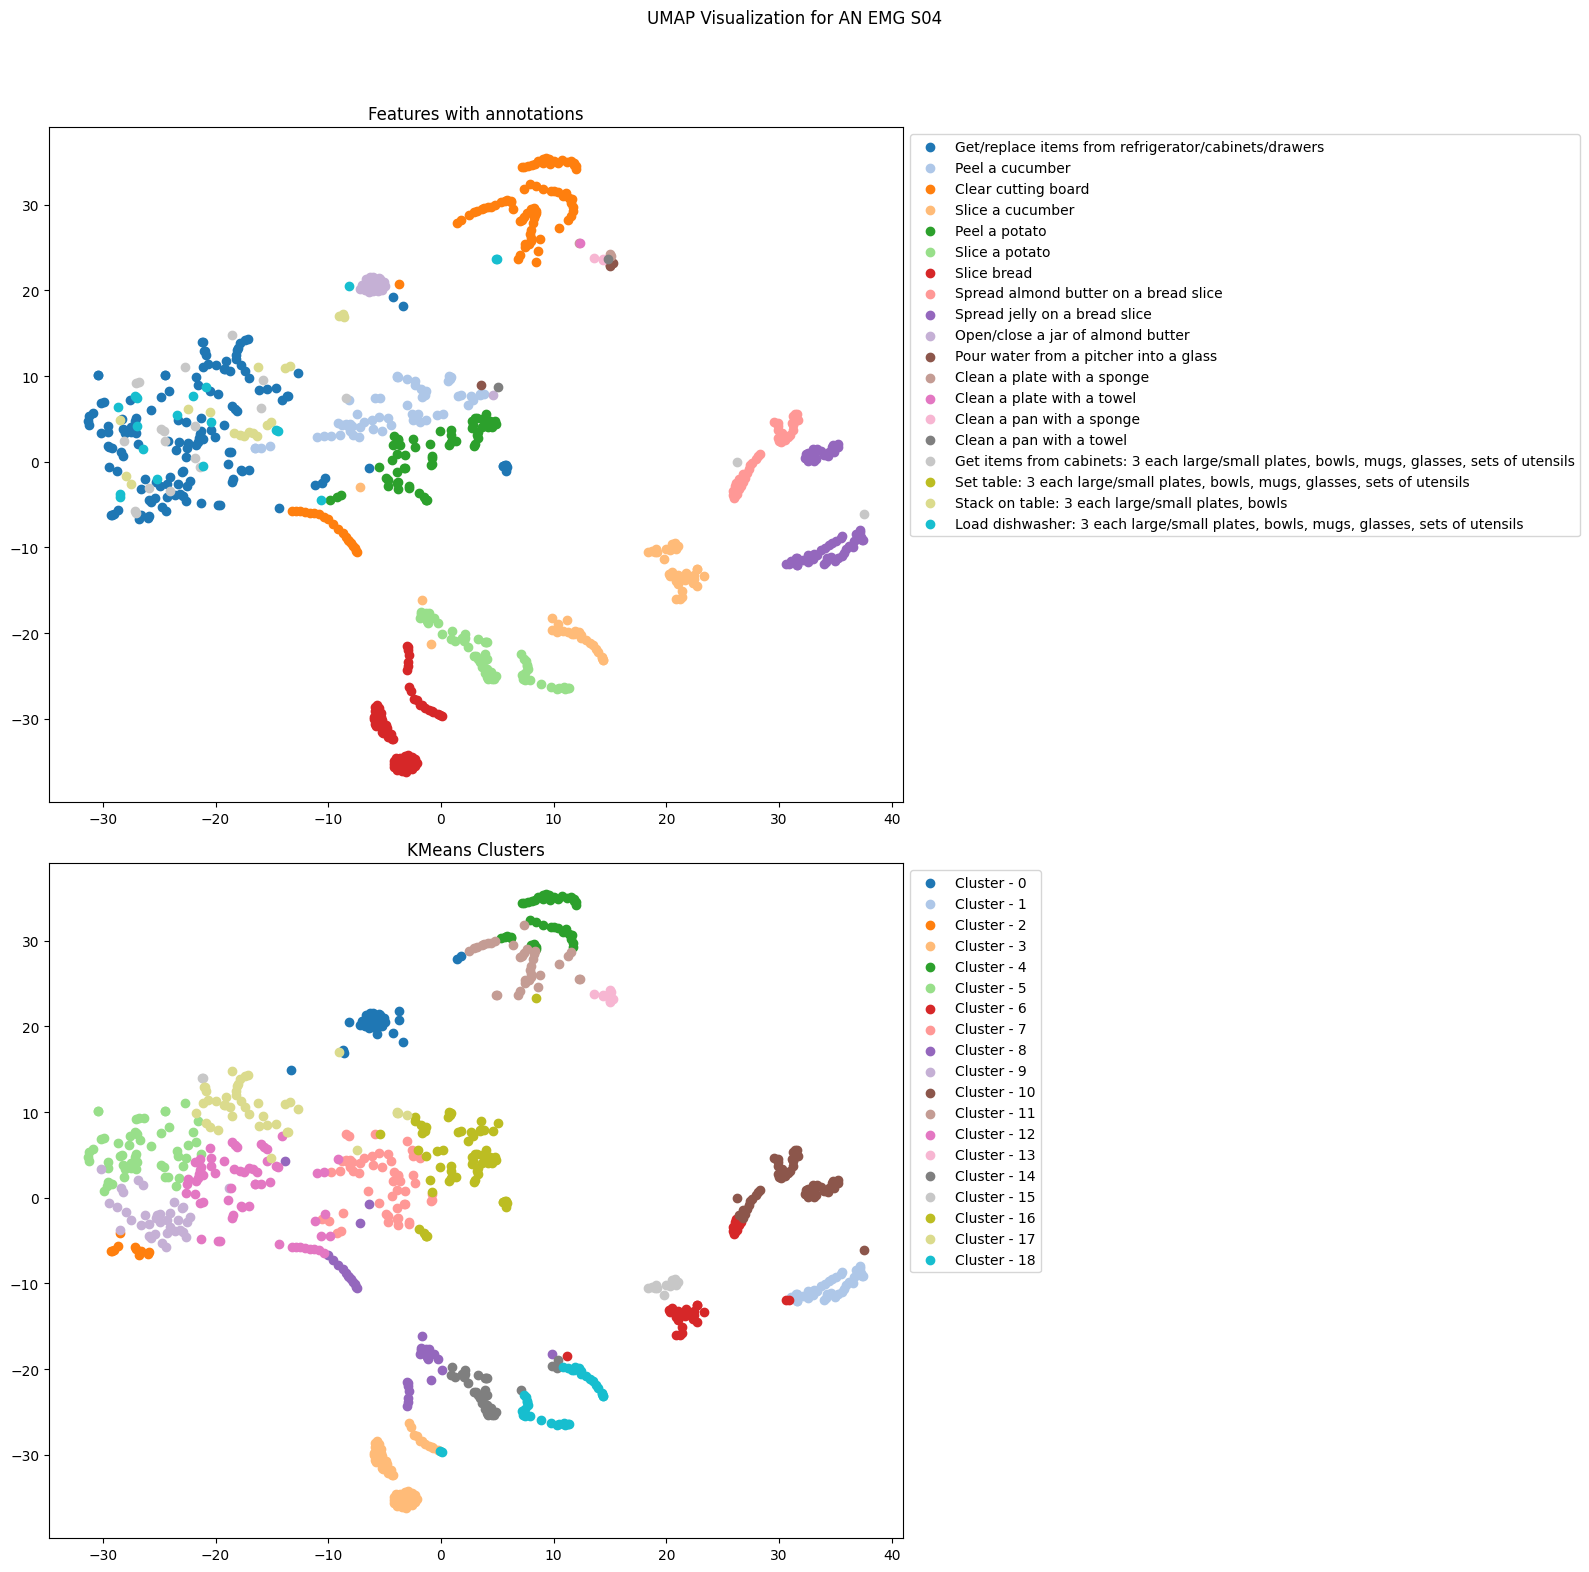

In [49]:
plot_features_labels_clusters_an("./EMG_preprocessed/EMG_S04_train.pkl", df_an_04, "AN EMG S04","EMG")